# Advanced Lane Detection

In [71]:
import os
import sys
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

root_dir = "/Users/xi/Documents/coding/udacity_self_driving/CarND-Advanced-Lane-Lines"
cam_cal_dir = os.path.join(root_dir, "camera_cal")
test_img_dir = os.path.join(root_dir, "test_images")
output_img_dir = os.path.join(root_dir, "output_images")

scale = 720/1280 # Scale the 1280 image down to 720 image
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

## Part I. Camera Calibration

In [3]:
objpoints = []
imgpoints = []

objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob(os.path.join(cam_cal_dir, "*.jpg"))
for idx, fname in enumerate(images):
    img = cv2.imread(os.path.join(cam_cal_dir, fname))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        # cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

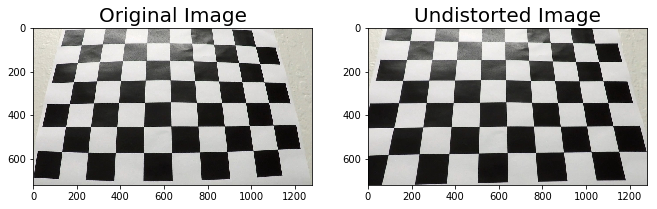

In [102]:
# Test undistortion
img = mpimg.imread(os.path.join(cam_cal_dir, 'calibration3.jpg'))
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=20)

## Part II. Color/gradient threshold

In [106]:
img = mpimg.imread(os.path.join(test_img_dir, 'test3.jpg'))
img = cv2.undistort(img, mtx, dist, None, mtx)

#### Absolute Sobel

In [107]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

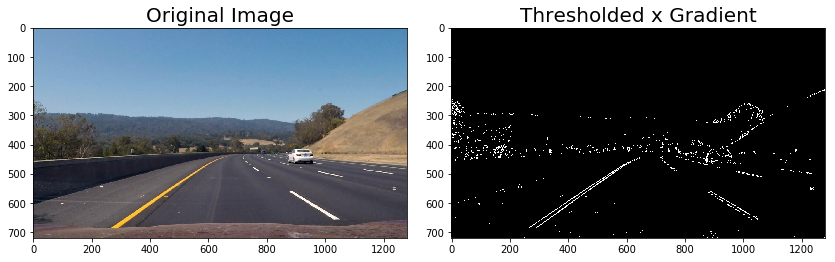

In [108]:
grad_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(30, 130))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded x Gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

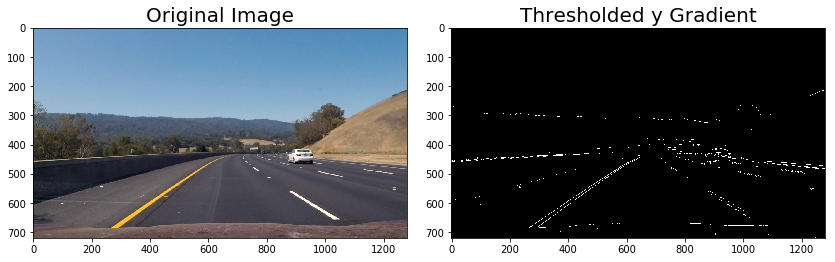

In [109]:
grad_binary = abs_sobel_thresh(image, orient='y',sobel_kernel=3, thresh=(70, 130))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded y Gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Magnitude of Gradient

In [41]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output


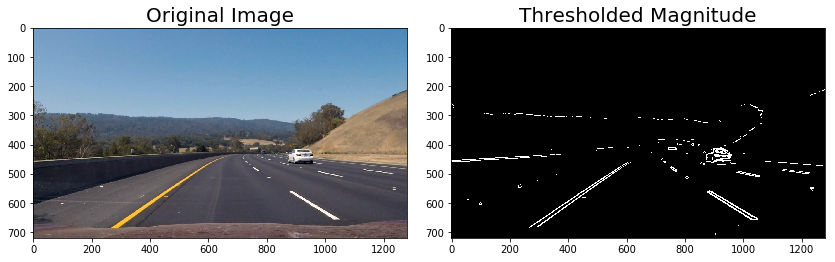

In [11]:
mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(80, 255))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Direction of Gradient

In [42]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgradient = np.arctan2(abs_sobely, abs_sobelx)

    binary_output = np.zeros_like(gray)
    binary_output[(absgradient >= thresh[0]) & (absgradient <= thresh[1])] = 1
    return binary_output

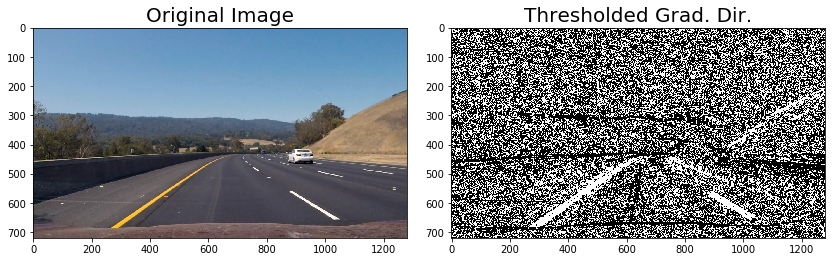

In [13]:
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [43]:
def hls_select(image, thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

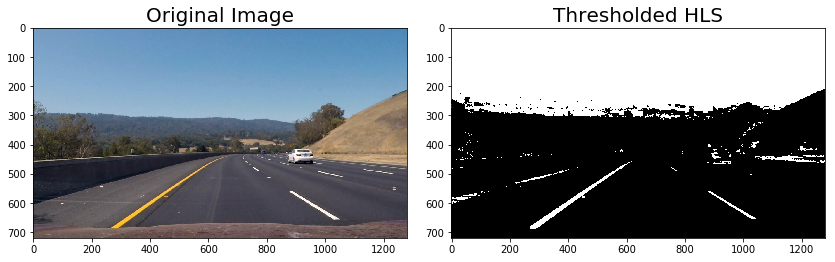

In [16]:
hls_binary = hls_select(image, thresh=(90, 255))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded HLS', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [52]:
def combine_thresh(image, debug=False):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(30, 230))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(30, 230))
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(80, 150))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_binary = hls_select(image, thresh=(100, 150))
    if debug:
        f, axarr = plt.subplots(2, 3, figsize=(11, 5))
        f.tight_layout()
        axarr[0][0].imshow(image)
        axarr[0][0].set_title('Original Image', fontsize=20)
        axarr[0][1].imshow(gradx)
        axarr[0][1].set_title('Sobel X Threshold', fontsize=20)
        axarr[0][2].imshow(grady)
        axarr[0][2].set_title('Sobel Y Threshold', fontsize=20)
        axarr[1][0].imshow(mag_binary)
        axarr[1][0].set_title('Magnitude Threshold', fontsize=20)
        axarr[1][1].imshow(dir_binary)
        axarr[1][1].set_title('Direction Threshold', fontsize=20)
        axarr[1][2].imshow(hls_binary)
        axarr[1][2].set_title('HLS Threshold', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
    return combined

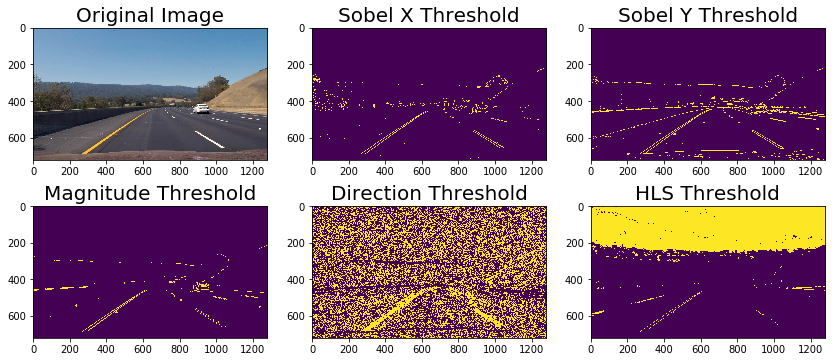

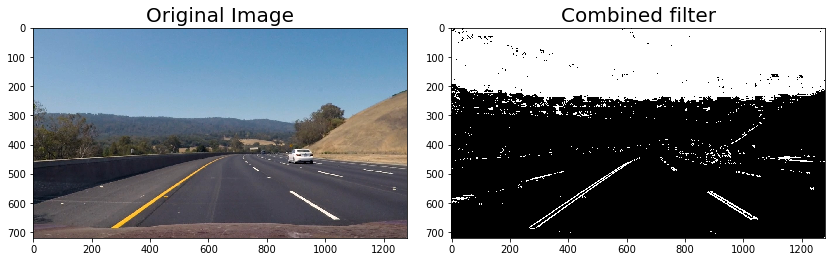

In [56]:
combined = combine_thresh(image, debug=True)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined filter', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Part III. Transform lane lines

In [59]:
def combine_thresh(image, debug=False):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(30, 230))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(30, 230))
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(80, 150))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_binary = hls_select(image, thresh=(100, 150))
    if debug:
        f, axarr = plt.subplots(2, 3, figsize=(11, 5))
        f.tight_layout()
        axarr[0][0].imshow(image)
        axarr[0][0].set_title('Original Image', fontsize=20)
        axarr[0][1].imshow(gradx)
        axarr[0][1].set_title('Sobel X Threshold', fontsize=20)
        axarr[0][2].imshow(grady)
        axarr[0][2].set_title('Sobel Y Threshold', fontsize=20)
        axarr[1][0].imshow(mag_binary)
        axarr[1][0].set_title('Magnitude Threshold', fontsize=20)
        axarr[1][1].imshow(dir_binary)
        axarr[1][1].set_title('Direction Threshold', fontsize=20)
        axarr[1][2].imshow(hls_binary)
        axarr[1][2].set_title('HLS Threshold', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & ~(grady == 1)) | ((mag_binary == 1) & ~(dir_binary == 1)) | (hls_binary == 1)] = 1
    return combined

In [233]:
apex, apey = 630, 258
offset_far = 600
offset_near = 200
src = np.float32([[290, 675],
                  [576, 463],
                  [710, 463],
                  [1050, 675]])
dst = np.float32([[250, 719],
                  [250, 100],
                  [1050, 100],
                  [1050, 719]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def warper(image, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, dsize=(image.shape[1],image.shape[0]), flags = cv2.INTER_LINEAR)
    return warped

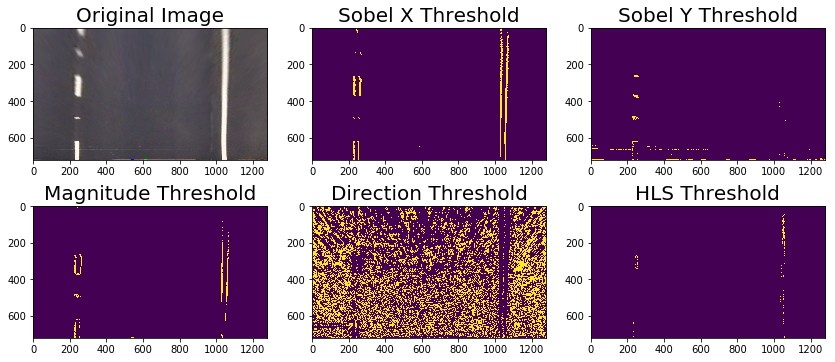

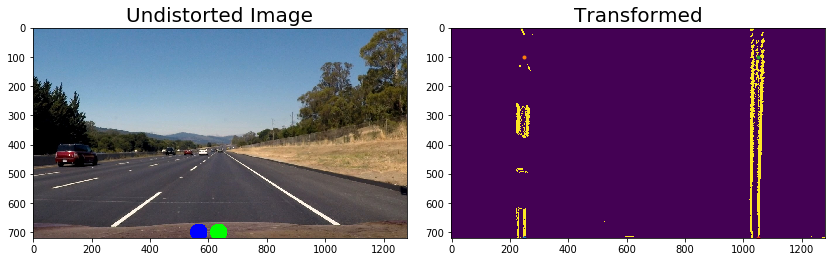

In [234]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

warped = warper(img, src, dst)
binary_warped = combine_thresh(warped, debug=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(binary_warped)
plt.plot(dst[0][0], dst[0][1], '.')
plt.plot(dst[1][0], dst[1][1], '.')
plt.plot(dst[2][0], dst[2][1], '.')
plt.plot(dst[3][0], dst[3][1], '.')
ax2.set_title('Transformed', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Determine the lane curvature

In [236]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def fit_line_init(binary_warped, nwindows = 9, debug=False):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if debug:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit

In [196]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def fit_line(binary_warped, debug=False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if debug:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure()
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return left_fit, right_fit

### Measuring Curvature

In [187]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def calc_curvature(yvals, fitx):
    y_eval = np.max(yvals)
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

def calc_position(yvals, left_fitx, right_fitx, center):
    y_index = np.argmax(yvals)
    left  = left_fitx[y_index]
    right = right_fitx[y_index]
    position = (left + right)/2  
    return position

### Draw lane

In [280]:
# Create an image to draw the lines on
def draw_lane(image, binary_warped, left_fit, right_fit, Minv, debug=False):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_curvature = calc_curvature(ploty, left_fitx)
    right_curvature = calc_curvature(ploty, right_fitx)
    
    center = binary_warped.shape[1] * xm_per_pix // 2
    position = calc_position(ploty, left_fitx, right_fitx, center) * xm_per_pix
    cv2.circle(image, (int(position//xm_per_pix), 700), 30, (0,255,0), -11)
    cv2.circle(image, (int(center//xm_per_pix), 700), 30, (0,0,255), -11)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

### Pipeline processing images

In [212]:
def process_image(image, debug=False):
    warped = warper(image, src, dst)
    binary_warped = combine_thresh(warped, debug=debug)
    left_fit, right_fit = fit_line_init(binary_warped, debug=debug)
    result = draw_lane(image, binary_warped, left_fit, right_fit, Minv, debug=debug)
    return result

In [276]:
left_line = Line(True)
right_line = Line(False)

[ -2.26692623e-03   2.81295286e+00  -6.74838135e+02] [  2.46638904e-04  -3.03763721e-01   1.21810065e+03]
64497.6051853 2003.58243768


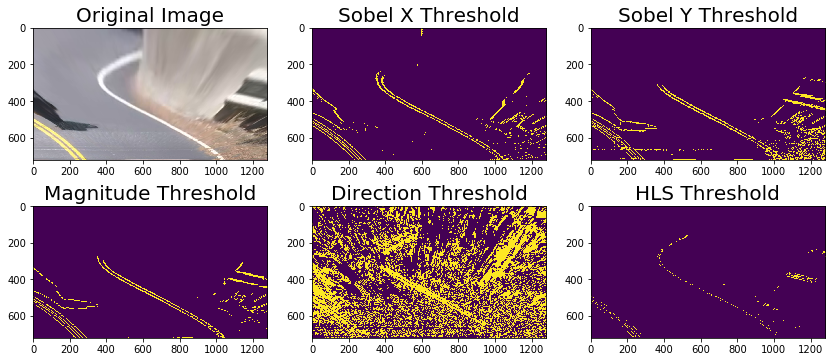

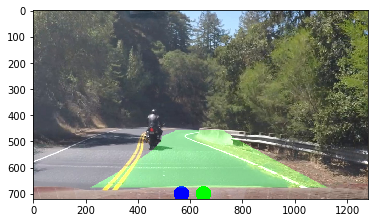

In [267]:
left_line = Line(True)
right_line = Line(False)
def process_image(image, debug=False):
    warped = warper(image, src, dst)
    binary_warped = combine_thresh(warped, debug=debug)
    left_fit = left_line.fit_line(binary_warped)
    right_fit = right_line.fit_line(binary_warped)
    result = draw_lane(image, binary_warped, left_fit, right_fit, Minv, debug=debug)
    return result

fname = "frame_%d.png" % 4
fname = os.path.join(root_dir, fname)
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
temp = process_image(img, debug=True)
plt.figure()
plt.imshow(temp)


[  4.23840014e-04  -1.76598157e-01   1.07708672e+02] [ -2.66782378e-04   3.27832861e-01   1.08800553e+03]
3528.33059196 2103.68675398


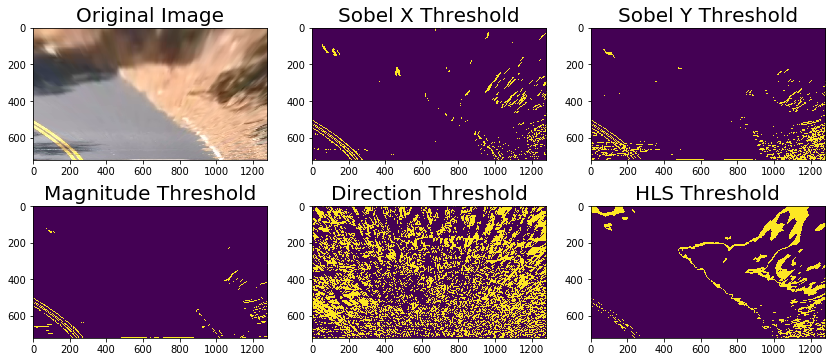

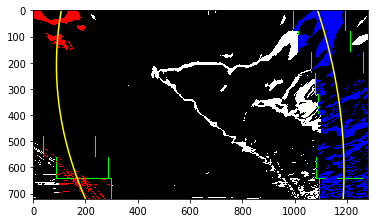

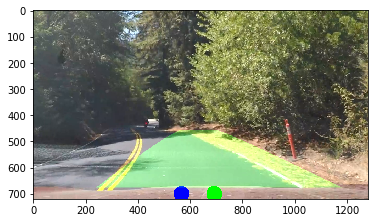

In [244]:
# Test how process_image works on single image

fname = "frame_%d.png" % i
fname = os.path.join(root_dir, fname)
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
temp = process_image(img, debug=True)
plt.figure()
plt.imshow(temp)

In [278]:
# Define a class to receive the characteristics of each line detection
class Line():
    history_num = 10
    def __init__(self, left_side=True):
        self.left_side = left_side
        self.cur_idx = 0
        self.detected = False  
        self.recent_xfitted = [None] * Line.history_num
        self.bestx = None     
        self.best_fit = None  
        self.current_fit = [np.array([False])]  
        self.diffs = np.array([0,0,0], dtype='float')
        
    def fit_line(self, binary_warped, debug=False):
        if self.detected:
            self._fit_line_cont(binary_warped)
            self.diffs = self.current_fit - self.best_fit
            if not self._sanity_check():
                self.detected = False
                self._fit_line_init(binary_warped)
        else:
            self._fit_line_init(binary_warped)
            
        self.recent_xfitted[self.cur_idx % Line.history_num] = self.current_fit
        self.cur_idx += 1
        self.best_fit = np.mean(self.recent_xfitted[:min(self.cur_idx, Line.history_num)], axis=0)
        return self.best_fit
    
    def _sanity_check(self):
        if np.mean(np.divide(self.diffs, self.current_fit)) > 0.2:
            return False
        return True
    
    def _fit_line_init(self, binary_warped, nwindows = 9):
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

        midpoint = np.int(histogram.shape[0]/2)
        if self.left_side:
            base = np.argmax(histogram[:midpoint])
        else:
            base = np.argmax(histogram[midpoint:]) + midpoint
        window_height = np.int(binary_warped.shape[0]/nwindows)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        current = base
        margin = 100
        minpix = 50
        left_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = current - margin
            win_xleft_high = current + margin
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            if len(good_left_inds) > minpix:
                current = np.int(np.mean(nonzerox[good_left_inds]))

        lane_inds = np.concatenate(left_lane_inds)

        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 
        self.current_fit = np.polyfit(y, x, 2)
        self.detected = True
    
    def _fit_line_cont(self, binary_warped, debug=False):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (self.best_fit[0]*(nonzeroy**2) + self.best_fit[1]*nonzeroy + self.best_fit[2] - margin)) & \
                          (nonzerox < (self.best_fit[0]*(nonzeroy**2) + self.best_fit[1]*nonzeroy + self.best_fit[2] + margin))) 
        
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 

        self.current_fit = np.polyfit(lefty, leftx, 2)

In [279]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_video_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip('challenge_video.mp4', audio=False)
new_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(project_video_output, audio=False)

41101.2135841 676609.422578
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



  0%|          | 0/485 [00:00<?, ?it/s]

35129.6857927 716298.61993



  0%|          | 2/485 [00:00<01:38,  4.91it/s]

28725.3699505 731635.234946
20911.9640974 628945.048931


  1%|          | 4/485 [00:00<01:38,  4.90it/s]


8427.75052004 455838.315559
2218.25472179 532058.295774



  1%|          | 6/485 [00:01<01:34,  5.06it/s]

4516.20317577 624104.113806



  1%|▏         | 7/485 [00:01<01:34,  5.04it/s]

14852.613347 758426.104518



  2%|▏         | 8/485 [00:01<01:36,  4.95it/s]

37851.9053785 901613.873902



  2%|▏         | 9/485 [00:01<01:37,  4.90it/s]

67952.889656 909171.940047



  2%|▏         | 10/485 [00:02<01:40,  4.72it/s]

105506.808769 884253.441314



  2%|▏         | 11/485 [00:02<01:43,  4.58it/s]

149860.726729 859346.543038



  2%|▏         | 12/485 [00:02<01:42,  4.61it/s]

200277.427068 835704.605176



  3%|▎         | 13/485 [00:02<01:48,  4.34it/s]

254254.961059 820471.413249
296003.947998 815736.872481



  3%|▎         | 15/485 [00:03<01:40,  4.68it/s]

330002.317458 839389.977314



  3%|▎         | 16/485 [00:03<01:41,  4.64it/s]

370534.820272 853139.519709



  4%|▎         | 17/485 [00:03<01:42,  4.57it/s]

432742.447379 858291.583581



  4%|▎         | 18/485 [00:03<01:44,  4.48it/s]

474720.104415 787719.946958



  4%|▍         | 19/485 [00:04<01:45,  4.41it/s]

461860.332331 644799.903596
382473.907223 527757.917799



  4%|▍         | 21/485 [00:04<01:38,  4.73it/s]

391923.258805 500854.096605
399499.632975 462602.906053



  5%|▍         | 23/485 [00:04<01:33,  4.96it/s]

397500.06858 421166.403203
389219.48443 391812.954427



  5%|▌         | 25/485 [00:05<01:31,  5.04it/s]

365419.851195 363374.3968



  5%|▌         | 26/485 [00:05<01:34,  4.87it/s]

338539.181679 328593.461916



  6%|▌         | 27/485 [00:05<01:38,  4.66it/s]

302117.228697 287180.383512



  6%|▌         | 28/485 [00:05<01:40,  4.55it/s]

282017.131305 282839.303046



  6%|▌         | 29/485 [00:06<01:39,  4.57it/s]

297875.775569 326187.462692



  6%|▌         | 30/485 [00:06<01:37,  4.67it/s]

372825.291324 362256.006505
356265.843059 329548.264743



  7%|▋         | 32/485 [00:06<01:34,  4.81it/s]

343142.754426 299027.201254



  7%|▋         | 33/485 [00:06<01:34,  4.77it/s]

338335.518904 280265.127296
330828.613997 258868.268334



  7%|▋         | 35/485 [00:07<01:30,  4.98it/s]

325846.863418 242947.51585
314348.099395 238324.314488



  8%|▊         | 37/485 [00:07<01:29,  5.02it/s]

305893.673702 235353.704985



  8%|▊         | 38/485 [00:07<01:31,  4.87it/s]

287312.170582 234566.790414



  8%|▊         | 39/485 [00:08<01:34,  4.72it/s]

275806.282082 230123.127384
257444.305998 227752.975399



  9%|▊         | 42/485 [00:08<01:26,  5.14it/s]

243914.680715 226259.305118
228197.356396 228807.327052



  9%|▉         | 43/485 [00:08<01:26,  5.11it/s]

208975.582829 227601.386201
187161.996922 224352.656847



  9%|▉         | 45/485 [00:09<01:24,  5.19it/s]

170762.288487 214370.148674
154232.885485 200033.918787



 10%|▉         | 47/485 [00:09<01:24,  5.21it/s]

151502.843955 189627.112841
138137.439156 176821.452587



 10%|█         | 49/485 [00:10<01:26,  5.01it/s]

120905.295988 167173.550081



 10%|█         | 50/485 [00:10<01:30,  4.81it/s]

105175.062168 158150.683161



 11%|█         | 51/485 [00:10<01:29,  4.85it/s]

88582.4572529 152230.697742
72742.285926 148195.286146



 11%|█         | 53/485 [00:10<01:26,  4.98it/s]

58342.0268184 126768.085702
55781.6753062 127980.054405



 11%|█▏        | 55/485 [00:11<01:24,  5.11it/s]

48253.3921184 131777.438987
39500.3090001


 12%|█▏        | 57/485 [00:11<01:24,  5.04it/s]

 129087.031881
25835.1148566 121551.71744
15465.8883501 116016.238538



 12%|█▏        | 59/485 [00:12<01:23,  5.08it/s]

7284.23622018 107877.509912
2990.16212465 105338.348176



 13%|█▎        | 61/485 [00:12<01:23,  5.08it/s]

3468.28062435 101678.960613
3214.83234441 97367.5968391



 13%|█▎        | 63/485 [00:12<01:21,  5.16it/s]

2726.9734325 109019.823941
9036.83084255 103984.742941



 13%|█▎        | 65/485 [00:13<01:22,  5.12it/s]

2710.95763953 98480.2822559
6612.97461711 100746.221385



 14%|█▍        | 67/485 [00:13<01:22,  5.10it/s]

13405.2821729 93110.4854087
20179.1403871 


 14%|█▍        | 68/485 [00:13<01:22,  5.06it/s]

80700.9700665
21370.4704286 76761.0547026



 14%|█▍        | 70/485 [00:14<01:21,  5.09it/s]

25103.7062738 70348.1575844



 15%|█▍        | 71/485 [00:14<01:22,  5.04it/s]

37369.5369955 65050.9693477



 15%|█▍        | 72/485 [00:14<01:25,  4.83it/s]

48446.3742736 59718.8017066



 15%|█▌        | 73/485 [00:14<01:24,  4.86it/s]

57848.0794793 55466.1385079
60820.1117062 50347.1554079



 15%|█▌        | 75/485 [00:15<01:21,  5.05it/s]

61244.9642354 48586.8389891
58780.7365456 47051.7230365



 16%|█▌        | 77/485 [00:15<01:19,  5.13it/s]

51351.6096346 57788.2989961
43173.8270628 74437.1311716



 16%|█▋        | 79/485 [00:16<01:18,  5.16it/s]

41585.2260584 88052.9954957
36283.400798 103565.425397



 17%|█▋        | 81/485 [00:16<01:18,  5.18it/s]

36193.2954659 121476.525592
35456.134315 142593.343581



 17%|█▋        | 84/485 [00:17<01:16,  5.23it/s]

35796.0111878 160887.938238
35397.30857 196900.246127



 18%|█▊        | 85/485 [00:17<01:16,  5.21it/s]

32499.0357331 218099.625909
29432.6899353 238958.126928



 18%|█▊        | 87/485 [00:17<01:16,  5.17it/s]

28094.8892077 238597.174675



 18%|█▊        | 88/485 [00:17<01:18,  5.04it/s]

26558.890969 235645.769516
23999.5263222 226217.758208



 19%|█▊        | 90/485 [00:18<01:19,  5.00it/s]

23955.8765448 209421.474671
22617.0323815 203912.135028



 19%|█▉        | 93/485 [00:18<01:15,  5.22it/s]

20904.9698582 193475.975515
19195.8741614 189225.756976



 19%|█▉        | 94/485 [00:18<01:15,  5.19it/s]

17029.3962978 172991.874149
16257.4515132 173063.217443



 20%|█▉        | 96/485 [00:19<01:16,  5.07it/s]

16557.8284635 168224.578232
17298.3294364 171291.127333



 20%|██        | 98/485 [00:19<01:13,  5.25it/s]

18211.7774455 176931.51157
20214.7332648 187799.649755



 21%|██        | 100/485 [00:20<01:13,  5.22it/s]

20734.3632973 206472.035991
22693.5528194 217353.340957



 21%|██        | 102/485 [00:20<01:19,  4.83it/s]

25304.6855938 236158.977081



 21%|██        | 103/485 [00:20<01:22,  4.65it/s]

28129.681502 251447.15668



 21%|██▏       | 104/485 [00:21<01:24,  4.50it/s]

31105.0041819 266195.352632
33185.3724458


 22%|██▏       | 105/485 [00:21<01:21,  4.67it/s]

 277635.887869
36637.6497089 273401.32845



 22%|██▏       | 108/485 [00:21<01:13,  5.10it/s]

39255.3760435 272188.578302
44994.3672776 258481.747352



 23%|██▎       | 110/485 [00:22<01:11,  5.26it/s]

50418.6605351 252547.222757
58624.210732 251127.318831



 23%|██▎       | 111/485 [00:22<01:10,  5.29it/s]

67308.6475814 253132.139476
78004.2956447


 23%|██▎       | 113/485 [00:22<01:13,  5.03it/s]

 255820.962073
88601.8535275 257749.138081
101148.145405 257793.379526



 24%|██▎       | 115/485 [00:23<01:11,  5.15it/s]

118402.880554 248464.426087
134732.816701 266430.661847



 24%|██▍       | 117/485 [00:23<01:11,  5.16it/s]

149784.60401 297041.296934
153153.50453 363021.096599



 25%|██▍       | 119/485 [00:23<01:11,  5.15it/s]

148330.85408 421895.140695
140519.979235 460968.584142



 25%|██▍       | 121/485 [00:24<01:14,  4.88it/s]

129069.94244 492846.287175



 25%|██▌       | 123/485 [00:24<01:13,  4.91it/s]

120904.883888 505433.882869
113249.11879 448484.099968



 26%|██▌       | 124/485 [00:24<01:12,  5.01it/s]

105470.26284 372207.553594
95350.9749861 292053.58598



 26%|██▌       | 126/485 [00:25<01:09,  5.19it/s]

84517.1707286 211903.847974



 26%|██▌       | 127/485 [00:25<01:13,  4.85it/s]

57535.246855 138579.093403
26813.7512862 98128.4191997



 27%|██▋       | 130/485 [00:26<01:09,  5.14it/s]

21678.0550266 64398.2537978
16842.5231309 41180.6220626



 27%|██▋       | 131/485 [00:26<01:07,  5.23it/s]

20328.5027454 23125.0080025
11558.5735785 9340.73948483



 28%|██▊       | 134/485 [00:26<01:06,  5.31it/s]

8590.07260403 6310.68293527
5576.68700002 6112.0788407



 28%|██▊       | 135/485 [00:27<01:06,  5.29it/s]

3595.40236648 8879.15867631
1831.6745152 12807.8972192



 28%|██▊       | 138/485 [00:27<01:05,  5.28it/s]

1852.02924118 19885.4104382
4384.34537236 17043.0446764



 29%|██▊       | 139/485 [00:27<01:09,  4.96it/s]

4301.47936022 13579.6311126



 29%|██▉       | 140/485 [00:28<01:10,  4.87it/s]

4377.13996015 9693.55582122
2112.79861339 6265.55760898



 29%|██▉       | 142/485 [00:28<01:08,  4.98it/s]

3210.78396452 5820.81583112
3140.70036105 7660.07263799



 30%|██▉       | 144/485 [00:28<01:06,  5.12it/s]

3519.76212205 10097.527421
3926.48471688 12852.1736337



 30%|███       | 146/485 [00:29<01:08,  4.93it/s]

5193.63056451 15810.2183381



 30%|███       | 147/485 [00:29<01:09,  4.87it/s]

8450.05171887 17438.9490108



 31%|███       | 148/485 [00:29<01:14,  4.55it/s]

13052.4497718 18434.8253586



 31%|███       | 149/485 [00:29<01:17,  4.33it/s]

13982.4870659 21244.2668534



 31%|███       | 150/485 [00:30<01:17,  4.33it/s]

15236.7508433 26160.5834747



 31%|███       | 151/485 [00:30<01:14,  4.47it/s]

16669.0197161 31583.1400474
18770.1589826


 32%|███▏      | 153/485 [00:30<01:11,  4.62it/s]

 37317.1799446
19840.9394412 39644.9819653



 32%|███▏      | 154/485 [00:31<01:15,  4.41it/s]

20858.0145532 43859.7646752



 32%|███▏      | 155/485 [00:31<01:14,  4.44it/s]

21825.1482762 48809.17828
19187.9804699 56998.6394706



 32%|███▏      | 157/485 [00:31<01:08,  4.80it/s]

18444.4213422 65293.2392311
14663.7363727 63220.4657142



 33%|███▎      | 159/485 [00:32<01:05,  5.00it/s]

11327.396916 67947.6521107
7995.92197039 66653.6121845



 33%|███▎      | 161/485 [00:32<01:03,  5.08it/s]

5092.27399584 66830.3427472
2857.53168391 67655.8555044



 34%|███▎      | 163/485 [00:32<01:02,  5.13it/s]

2049.17197232 70873.868269
1727.96095156 71594.7048091



 34%|███▍      | 165/485 [00:33<01:02,  5.16it/s]

1809.39197226 71897.3383016
1703.39859433 70427.6287418



 34%|███▍      | 167/485 [00:33<01:01,  5.14it/s]

1724.21670394 69593.569861
1969.63147115 77520.54653



 35%|███▍      | 169/485 [00:34<01:00,  5.22it/s]

2732.31723956 69812.9510463
4193.81066426 76057.2107511



 35%|███▌      | 171/485 [00:34<01:00,  5.16it/s]

6437.11062532 84455.8076957
9555.76267989 93674.5590193



 36%|███▌      | 173/485 [00:34<00:59,  5.27it/s]

11047.5560722 101003.496708
12034.739783 109761.599029



 36%|███▌      | 175/485 [00:35<00:58,  5.26it/s]

13207.4847459 118578.484242
13895.4576761 125884.119634



 36%|███▋      | 177/485 [00:35<00:59,  5.21it/s]

14549.5906441 133505.885078
15007.6819151 144412.709403



 37%|███▋      | 179/485 [00:35<00:58,  5.21it/s]

15443.1803015 167356.385819
15635.6782094 180843.682798



 37%|███▋      | 181/485 [00:36<00:58,  5.18it/s]

15698.9979319 188870.462811
16252.5439607 198684.768351



 38%|███▊      | 183/485 [00:36<00:59,  5.12it/s]

16893.4644375 182025.232973



 38%|███▊      | 184/485 [00:36<00:59,  5.05it/s]

17358.999067 145447.117469
17398.6717555 114699.799203



 38%|███▊      | 186/485 [00:37<00:58,  5.07it/s]

18309.8988216 94536.3211367



 39%|███▊      | 187/485 [00:37<00:59,  5.05it/s]

19741.0050047 78836.8708277
19994.875833 60923.719158



 39%|███▉      | 189/485 [00:37<00:58,  5.05it/s]

20341.5673832 45614.4314089
21056.6976752 32407.8136412



 39%|███▉      | 191/485 [00:38<00:57,  5.08it/s]

21606.1635632 21225.5279748
22081.0360152 12057.9825969



 40%|███▉      | 193/485 [00:38<00:57,  5.06it/s]

22906.9623214 11874.7723615
23112.5652785 16320.0654601



 40%|████      | 195/485 [00:39<00:57,  5.07it/s]

24130.4875186 20852.1028182
24518.3431842 23038.4343394



 41%|████      | 197/485 [00:39<00:56,  5.07it/s]

24853.3987756 23794.702767
27657.0606591 27318.0140837



 41%|████      | 199/485 [00:39<00:55,  5.13it/s]

30630.0103486 30478.4964054
33606.7988558 33488.0791001



 41%|████▏     | 201/485 [00:40<00:54,  5.17it/s]

38098.0936188 38072.0733884
37675.552337 37661.2494694



 42%|████▏     | 203/485 [00:40<00:55,  5.11it/s]

36675.9907126 36683.5001235
36254.7229461


 42%|████▏     | 204/485 [00:40<00:55,  5.05it/s]

 36263.9335548
35485.5960851 35497.2684284



 42%|████▏     | 206/485 [00:41<00:54,  5.10it/s]

36065.746692 36081.2379697
34616.0970165


 43%|████▎     | 208/485 [00:41<00:54,  5.09it/s]

 34625.3577427
32381.2502306 32390.197196
30185.1252766 30191.6436399



 43%|████▎     | 210/485 [00:42<00:53,  5.10it/s]

28839.3015202 28842.2456231
25505.6447527 25506.8074555



 44%|████▎     | 212/485 [00:42<00:53,  5.14it/s]

28519.6739652 28518.8232006
30705.8231466 30704.9391972



 44%|████▍     | 214/485 [00:42<00:52,  5.13it/s]

33052.391797 33049.7997998
33709.547523


 45%|████▍     | 216/485 [00:43<00:53,  5.01it/s]

 33706.929052
32728.4348985 32725.856058
32499.5933292 32498.5370949



 45%|████▍     | 218/485 [00:43<00:52,  5.11it/s]

32045.3750043 32044.3264228
32496.3738801 32496.5313411



 45%|████▌     | 220/485 [00:43<00:51,  5.11it/s]

31027.8307081 31027.8307081
30909.1780264 30909.1780264



 46%|████▌     | 222/485 [00:44<00:51,  5.09it/s]

27461.8018796 27461.8018796



 46%|████▌     | 223/485 [00:44<00:51,  5.05it/s]

24961.4172194 24961.4172194



 46%|████▌     | 224/485 [00:44<00:52,  5.00it/s]

23599.0512294 23599.0512294
24587.9083495 24587.9083495



 47%|████▋     | 226/485 [00:45<00:58,  4.43it/s]

26084.2919543 26084.2919543
27372.3824705 27372.3824705



 47%|████▋     | 228/485 [00:45<00:53,  4.79it/s]

28697.4282385 28697.4282385
28602.1011145 28602.1011145



 47%|████▋     | 230/485 [00:46<00:51,  4.96it/s]

28557.8936578 28557.8936578
27572.062161 27572.062161



 48%|████▊     | 232/485 [00:46<00:50,  5.04it/s]

27390.8594955 27390.8594955
28095.830726 28095.830726



 48%|████▊     | 234/485 [00:46<00:48,  5.14it/s]

26303.9109864 26303.9109864
23577.9248503


 49%|████▊     | 236/485 [00:47<00:49,  5.05it/s]

 23577.9248503
20662.4684565 20662.4684565
19271.8316497 19271.8316497



 49%|████▉     | 238/485 [00:47<00:48,  5.07it/s]

18043.0599593 18043.0599593
18070.5088564 18070.5088564



 49%|████▉     | 240/485 [00:48<00:47,  5.13it/s]

18324.6217266 18324.6217266
19498.0674501 19498.0674501



 50%|████▉     | 242/485 [00:48<00:47,  5.15it/s]

20278.5216568 20278.5216568
19442.6601419 19442.6601419



 50%|█████     | 244/485 [00:48<00:47,  5.03it/s]

19377.7205407 19377.7205407



 51%|█████     | 245/485 [00:48<00:48,  4.98it/s]

19376.584473 19376.584473
19827.6668556 19827.6668556



 51%|█████     | 247/485 [00:49<00:47,  5.03it/s]

19871.5542291 19871.5542291



 51%|█████     | 248/485 [00:49<00:47,  5.01it/s]

18999.2381525 18999.2381525
17534.8124097 17534.8124097



 52%|█████▏    | 250/485 [00:49<00:46,  5.03it/s]

16491.4933149 16491.4933149



 52%|█████▏    | 251/485 [00:50<00:46,  5.00it/s]

15485.1260467 15485.1260467
14834.6753395 14834.6753395



 52%|█████▏    | 253/485 [00:50<00:46,  5.03it/s]

15061.8149302 15061.8149302



 52%|█████▏    | 254/485 [00:50<00:46,  4.99it/s]

15763.6062579 15763.6062579
16457.6943777 16457.6943777



 53%|█████▎    | 256/485 [00:51<00:45,  5.00it/s]

16816.6667294 16816.6667294



 53%|█████▎    | 257/485 [00:51<00:45,  4.98it/s]

16889.1813361 16889.1813361



 53%|█████▎    | 258/485 [00:51<00:45,  4.94it/s]

17768.6129148 17768.6129148
19145.3200209 19145.3200209



 54%|█████▎    | 260/485 [00:51<00:45,  4.99it/s]

20940.5771444 20940.5771444
22781.8210821 22781.8210821



 54%|█████▍    | 262/485 [00:52<00:44,  5.03it/s]

23591.3440201 23591.3440201
24843.7065365 24843.7065365



 54%|█████▍    | 264/485 [00:52<00:43,  5.05it/s]

26310.9223532 26310.9223532



 55%|█████▍    | 265/485 [00:52<00:43,  5.02it/s]

27758.0073314 27758.0073314
29058.2716354 29058.2716354



 55%|█████▌    | 267/485 [00:53<00:42,  5.10it/s]

31292.8667725 31292.8667725
34220.3511668 34220.3511668



 55%|█████▌    | 269/485 [00:53<00:42,  5.07it/s]

36205.3043632 36205.3043632
36131.7551809 36131.7551809



 56%|█████▌    | 271/485 [00:54<00:41,  5.11it/s]

34926.4008595 34926.4008595
34734.5209512 34734.5209512



 56%|█████▋    | 273/485 [00:54<00:41,  5.06it/s]

34438.3559671 34438.3559671
34079.4345997


 56%|█████▋    | 274/485 [00:54<00:41,  5.03it/s]

 34079.4345997
33132.8322281 33132.8322281



 57%|█████▋    | 276/485 [00:55<00:41,  5.03it/s]

32434.9071662 32434.9071662
32063.6712873 


 57%|█████▋    | 278/485 [00:55<00:41,  5.02it/s]

32063.6712873
29640.9753394 29640.9753394
29681.2723551 29681.2723551



 58%|█████▊    | 280/485 [00:55<00:40,  5.07it/s]

30360.3597866 30360.3597866
33430.7577292 33430.7577292



 58%|█████▊    | 282/485 [00:56<00:39,  5.10it/s]

34435.1708145 34435.1708145
35535.9472569 35535.9472569



 59%|█████▊    | 284/485 [00:56<00:39,  5.09it/s]

34893.7265141 34893.7265141
34662.3126972 34662.3126972



 59%|█████▉    | 286/485 [00:57<00:38,  5.11it/s]

33876.8793584 33876.8793584
32696.4829641 32696.4829641



 59%|█████▉    | 288/485 [00:57<00:39,  5.04it/s]

32885.6498351 32885.6498351
31179.1575522 31179.1575522



 60%|█████▉    | 290/485 [00:57<00:38,  5.06it/s]

28473.0862395 28473.0862395
25258.2957289 25258.2957289



 60%|██████    | 292/485 [00:58<00:38,  5.05it/s]

24858.462834 24858.462834
22781.6911979


 61%|██████    | 294/485 [00:58<00:38,  5.01it/s]

 22781.6911979
22233.5829371 22233.5829371
23424.3789618 23424.3789618



 61%|██████    | 296/485 [00:59<00:37,  5.00it/s]

24324.6186281 24324.6186281
23541.0925025 23541.0925025



 61%|██████▏   | 298/485 [00:59<00:37,  5.00it/s]

22540.201797 22540.201797
22493.9103658 22493.9103658



 62%|██████▏   | 300/485 [00:59<00:36,  5.09it/s]

24038.227847 24038.227847
24851.9571156


 62%|██████▏   | 301/485 [01:00<00:36,  5.04it/s]

 24851.9571156
24464.8550305 24464.8550305



 62%|██████▏   | 303/485 [01:00<00:36,  5.05it/s]

23701.6218636 23701.6218636
23038.4000821 23038.4000821



 63%|██████▎   | 305/485 [01:00<00:35,  5.11it/s]

20763.4104796 20763.4104796
18903.8196525 18903.8196525



 63%|██████▎   | 307/485 [01:01<00:34,  5.09it/s]

18101.1678181 18101.1678181



 64%|██████▎   | 308/485 [01:01<00:35,  4.98it/s]

17315.8647067 17315.8647067



 64%|██████▎   | 309/485 [01:01<00:35,  4.96it/s]

15987.6104071 15987.6104071
14422.7476989 14422.7476989



 64%|██████▍   | 311/485 [01:02<00:34,  5.04it/s]

13214.50018 13214.50018
13192.2025038 13192.2025038



 65%|██████▍   | 313/485 [01:02<00:34,  5.03it/s]

12985.3486671 12985.3486671
12551.6599807 12551.6599807



 65%|██████▍   | 315/485 [01:02<00:33,  5.01it/s]

12168.0606907 12168.0606907
11825.6119141 11825.6119141



 65%|██████▌   | 317/485 [01:03<00:33,  5.01it/s]

10933.8688092 10933.8688092
10194.3363847


 66%|██████▌   | 319/485 [01:03<00:33,  5.03it/s]

 10194.3363847
9150.26576456 9150.26576456
8120.04563148 8120.04563148



 66%|██████▌   | 321/485 [01:04<00:32,  5.00it/s]

7129.48811281 7129.48811281
5857.07082311 5857.07082311



 67%|██████▋   | 323/485 [01:04<00:32,  4.99it/s]

6148.73218213 6148.73218213



 67%|██████▋   | 324/485 [01:04<00:32,  4.97it/s]

5982.22599302 5982.22599302



 67%|██████▋   | 325/485 [01:04<00:32,  4.95it/s]

5545.58604278 5545.58604278
5056.67849128 5056.67849128



 67%|██████▋   | 327/485 [01:05<00:31,  5.00it/s]

4975.09074677 4975.09074677



 68%|██████▊   | 328/485 [01:05<00:31,  4.94it/s]

4742.26579286 4742.26579286



 68%|██████▊   | 329/485 [01:05<00:32,  4.83it/s]

4515.3196353 4515.3196353



 68%|██████▊   | 330/485 [01:05<00:32,  4.73it/s]

4388.37077196 4388.37077196



 68%|██████▊   | 331/485 [01:06<00:33,  4.60it/s]

4263.82439137 4263.82439137



 68%|██████▊   | 332/485 [01:06<00:33,  4.50it/s]

3992.60707984 3992.60707984



 69%|██████▊   | 333/485 [01:06<00:34,  4.43it/s]

3293.00372339 3293.00372339



 69%|██████▉   | 334/485 [01:06<00:33,  4.50it/s]

2946.47873832 2946.47873832



 69%|██████▉   | 335/485 [01:07<00:33,  4.48it/s]

2822.89474696 2822.89474696



 69%|██████▉   | 336/485 [01:07<00:33,  4.44it/s]

2958.16024035 2958.16024035



 69%|██████▉   | 337/485 [01:07<00:33,  4.41it/s]

3021.48520878 3021.48520878



 70%|██████▉   | 338/485 [01:07<00:33,  4.40it/s]

3235.76123268 3235.76123268



 70%|██████▉   | 339/485 [01:07<00:33,  4.35it/s]

3413.74945469 3413.74945469



 70%|███████   | 340/485 [01:08<00:32,  4.40it/s]

3586.93272298 3586.93272298



 70%|███████   | 341/485 [01:08<00:33,  4.33it/s]

3746.77652646 3746.77652646



 71%|███████   | 342/485 [01:08<00:32,  4.41it/s]

4044.37093194 4044.37093194



 71%|███████   | 343/485 [01:08<00:31,  4.47it/s]

4216.17945636 4216.17945636
4226.50003505 4226.50003505



 71%|███████   | 345/485 [01:09<00:29,  4.72it/s]

4172.68280096 4172.68280096



 71%|███████▏  | 346/485 [01:09<00:29,  4.76it/s]

3950.38739987 3950.38739987



 72%|███████▏  | 347/485 [01:09<00:28,  4.79it/s]

3873.69721362 3873.69721362



 72%|███████▏  | 348/485 [01:09<00:28,  4.75it/s]

3776.45966642 3776.45966642



 72%|███████▏  | 349/485 [01:10<00:28,  4.80it/s]

3903.11595206 3903.11595206
4345.45013296 4345.45013296



 72%|███████▏  | 351/485 [01:10<00:27,  4.85it/s]

4847.86821565 4847.86821565



 73%|███████▎  | 352/485 [01:10<00:27,  4.85it/s]

5253.0351417 5253.0351417
5601.80942397 5601.80942397



 73%|███████▎  | 354/485 [01:11<00:29,  4.44it/s]

5643.00776477 5643.00776477



 73%|███████▎  | 355/485 [01:11<00:29,  4.43it/s]

5709.2056933 5709.2056933
5775.65075484 5775.65075484



 74%|███████▎  | 357/485 [01:11<00:26,  4.74it/s]

5802.60220662 5802.60220662
5884.02342273 5884.02342273



 74%|███████▍  | 359/485 [01:12<00:25,  4.87it/s]

5400.28722876 5400.28722876
4632.98456983


 74%|███████▍  | 360/485 [01:12<00:25,  4.87it/s]

 4632.98456983
3779.09625262


 74%|███████▍  | 361/485 [01:12<00:25,  4.88it/s]

 3779.09625262



 75%|███████▍  | 362/485 [01:12<00:25,  4.88it/s]

3072.62275139 3072.62275139



 75%|███████▍  | 363/485 [01:13<00:24,  4.88it/s]

2635.02552598 2635.02552598
2699.70268007 2699.70268007



 75%|███████▌  | 365/485 [01:13<00:24,  4.89it/s]

2810.26661932 2810.26661932
2919.51531882 2919.51531882



 76%|███████▌  | 367/485 [01:13<00:23,  4.92it/s]

2922.85519604 2922.85519604
2796.51477641 2796.51477641



 76%|███████▌  | 369/485 [01:14<00:23,  5.04it/s]

2909.3129959 2909.3129959



 76%|███████▋  | 370/485 [01:14<00:23,  4.98it/s]

2811.54131988 2811.54131988



 76%|███████▋  | 371/485 [01:14<00:23,  4.95it/s]

2845.03352082 2845.03352082



 77%|███████▋  | 372/485 [01:14<00:23,  4.87it/s]

2886.8635255 2886.8635255



 77%|███████▋  | 373/485 [01:15<00:23,  4.85it/s]

2873.04513814 2873.04513814
2763.95673941


 77%|███████▋  | 375/485 [01:15<00:22,  4.82it/s]

 2763.95673941
2624.0130311 2624.0130311



 78%|███████▊  | 376/485 [01:15<00:22,  4.82it/s]

2638.90749108 2638.90749108



 78%|███████▊  | 377/485 [01:15<00:22,  4.86it/s]

2832.11704326 2832.11704326



 78%|███████▊  | 378/485 [01:16<00:21,  4.88it/s]

3267.63897367 3267.63897367
3741.86014079 3741.86014079



 78%|███████▊  | 380/485 [01:16<00:21,  4.95it/s]

4809.61904057 4809.61904057
4997.67051631 4997.67051631



 79%|███████▉  | 382/485 [01:16<00:20,  4.98it/s]

5128.07835554 5128.07835554
5418.62400203 5418.62400203



 79%|███████▉  | 384/485 [01:17<00:20,  4.99it/s]

5728.06819008 5728.06819008
6526.52390685 6526.52390685



 80%|███████▉  | 386/485 [01:17<00:19,  5.04it/s]

6756.13519217 6756.13519217



 80%|███████▉  | 387/485 [01:17<00:19,  4.96it/s]

6379.70097648 6379.70097648
5895.44149648 5895.44149648



 80%|████████  | 389/485 [01:18<00:19,  4.98it/s]

5661.40655687 5661.40655687
5347.7316451 5347.7316451



 81%|████████  | 391/485 [01:18<00:18,  5.06it/s]

6247.95556174 6247.95556174
8165.53269851 


 81%|████████  | 393/485 [01:19<00:18,  5.07it/s]

8165.53269851
10338.9797244 10338.9797244
13299.274017 13299.274017



 81%|████████▏ | 395/485 [01:19<00:17,  5.03it/s]

12904.5038265 12904.5038265
13146.7281731


 82%|████████▏ | 397/485 [01:19<00:17,  4.94it/s]

 13146.7281731
14169.2258977 14169.2258977



 82%|████████▏ | 398/485 [01:20<00:17,  4.91it/s]

15657.3114485 15657.3114485
17443.0956373 17443.0956373



 82%|████████▏ | 400/485 [01:20<00:16,  5.03it/s]

19860.6831512 19860.6831512
21012.3960483


 83%|████████▎ | 401/485 [01:20<00:16,  5.00it/s]

 21012.3960483
19975.1943892 19975.1943892



 83%|████████▎ | 403/485 [01:21<00:16,  5.04it/s]

18593.8721698 18593.8721698
16537.1396737 16537.1396737



 84%|████████▎ | 405/485 [01:21<00:16,  4.99it/s]

18503.6463606 18503.6463606
20774.1520887 20774.1520887



 84%|████████▍ | 407/485 [01:21<00:15,  4.92it/s]

23420.4491098 23420.4491098
23624.115893 23624.115893



 84%|████████▍ | 409/485 [01:22<00:15,  5.02it/s]

24510.9325254 24510.9325254
24421.6224785 24421.6224785



 85%|████████▍ | 411/485 [01:22<00:14,  5.03it/s]

25259.6994062 25259.6994062
27118.1805791


 85%|████████▍ | 412/485 [01:22<00:14,  5.02it/s]

 27118.1805791
30470.7558136 30470.7558136



 85%|████████▌ | 414/485 [01:23<00:14,  5.03it/s]

32443.9865099 32443.9865099
34033.8087202 34033.8087202



 86%|████████▌ | 416/485 [01:23<00:13,  5.03it/s]

36177.3056925 36177.3056925
37960.8419815


 86%|████████▌ | 418/485 [01:24<00:13,  5.01it/s]

 37960.8419815
42101.4872337 42101.4872337
48002.1615096 48002.1615096



 87%|████████▋ | 420/485 [01:24<00:13,  5.00it/s]

53072.8128008 53072.8128008
58566.2181664 58566.2181664



 87%|████████▋ | 422/485 [01:24<00:12,  5.13it/s]

63623.7934336 63623.7934336
65676.9903261


 87%|████████▋ | 423/485 [01:25<00:12,  5.09it/s]

 65676.9903261
71165.4985609 71165.4985609



 88%|████████▊ | 425/485 [01:25<00:11,  5.09it/s]

74813.0466416 74813.0466416
78020.7037893 78020.7037893



 88%|████████▊ | 427/485 [01:25<00:11,  5.11it/s]

81279.9803191 81279.9803191
84094.6757415


 88%|████████▊ | 429/485 [01:26<00:11,  5.08it/s]

 84094.6757415
82030.213421 82030.213421
81050.830442 81050.830442



 89%|████████▉ | 431/485 [01:26<00:10,  5.04it/s]

81253.7709869 81253.7709869
81380.3705999 81380.3705999



 89%|████████▉ | 433/485 [01:27<00:10,  5.06it/s]

81696.4133043 81696.4133043
78655.9332777 78655.9332777



 90%|████████▉ | 435/485 [01:27<00:09,  5.03it/s]

73233.6936832 73233.6936832
61145.2091074 61145.2091074



 90%|█████████ | 437/485 [01:27<00:09,  5.01it/s]

59015.6287636 59015.6287636
57798.8916202 57798.8916202



 91%|█████████ | 439/485 [01:28<00:09,  5.04it/s]

56398.444211 56398.444211
56014.3080041 56014.3080041



 91%|█████████ | 441/485 [01:28<00:09,  4.47it/s]

54619.9056946 54619.9056946
53929.0289819 53929.0289819



 91%|█████████▏| 443/485 [01:29<00:08,  4.80it/s]

53902.5774526 53902.5774526
56573.4799596 56573.4799596



 92%|█████████▏| 445/485 [01:29<00:08,  4.92it/s]

62865.6738802 62865.6738802
76280.359213 76280.359213



 92%|█████████▏| 447/485 [01:29<00:08,  4.38it/s]

80056.0681449 80056.0681449
84386.7804589 84386.7804589



 93%|█████████▎| 449/485 [01:30<00:07,  4.72it/s]

87871.3021598 87871.3021598
93236.6911944 93236.6911944



 93%|█████████▎| 451/485 [01:30<00:06,  4.93it/s]

96841.0494834 96841.0494834
99941.8320094 99941.8320094



 93%|█████████▎| 453/485 [01:31<00:06,  5.02it/s]

104702.330698 104702.330698



 94%|█████████▎| 454/485 [01:31<00:06,  4.99it/s]

108063.293066 108063.293066
111075.23193 111075.23193



 94%|█████████▍| 456/485 [01:31<00:05,  5.03it/s]

112958.858459 112958.858459
114151.374291 114151.374291



 94%|█████████▍| 458/485 [01:32<00:05,  5.11it/s]

115286.992107 115286.992107
117134.476092 117134.476092



 95%|█████████▍| 460/485 [01:32<00:04,  5.13it/s]

116149.396656 116149.396656
114102.47801 114102.47801



 95%|█████████▌| 462/485 [01:32<00:04,  5.14it/s]

112523.917267 112523.917267
102325.806948 102325.806948



 96%|█████████▌| 464/485 [01:33<00:04,  5.22it/s]

91061.0280795 91061.0280795
89109.4973091 89109.4973091



 96%|█████████▌| 466/485 [01:33<00:03,  5.17it/s]

81044.6592098 81044.6592098
76485.7513833 76485.7513833



 96%|█████████▋| 468/485 [01:34<00:03,  5.17it/s]

72287.6822035 72287.6822035



 97%|█████████▋| 469/485 [01:34<00:03,  4.69it/s]

67398.9812167 67398.9812167



 97%|█████████▋| 471/485 [01:34<00:02,  4.76it/s]

64233.528398 64233.528398
55854.825739 55854.825739



 97%|█████████▋| 472/485 [01:34<00:02,  4.62it/s]

55269.5855089 55269.5855089



 98%|█████████▊| 473/485 [01:35<00:02,  4.32it/s]

59375.7796811 59375.7796811
53959.6062725 53959.6062725



 98%|█████████▊| 475/485 [01:35<00:02,  4.76it/s]

50196.2765792 50196.2765792
50016.3463515 50016.3463515



 98%|█████████▊| 477/485 [01:36<00:01,  4.99it/s]

47205.2059917 47205.2059917
43471.5405217 43471.5405217



 99%|█████████▉| 480/485 [01:36<00:01,  4.69it/s]

41080.9183574 41080.9183574
39599.9104895 39599.9104895



 99%|█████████▉| 481/485 [01:36<00:00,  4.85it/s]

43378.9527312 43378.9527312
41949.838188 41949.838188



100%|█████████▉| 483/485 [01:37<00:00,  5.02it/s]

39726.2730241 39726.2730241
48174.4112248 48174.4112248



100%|██████████| 485/485 [01:37<00:00,  5.09it/s]


44981.3684573 44981.3684573
[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 6min 1s, sys: 39.9 s, total: 6min 40s
Wall time: 1min 38s


In [249]:
i = 0
clip1.save_frame("frame_%d.png" % i, t=i)